In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2 # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

import numpy as np
import numpy.ma as ma
import h5py

import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
import tensorflow as tf

import sys
sys.path.insert(0, '../api_tutorials')
from bqsr_cnn import parse_args, read_to_bqsr_tensor, bqsr_get_metric_dict, bqsr_bed_file_to_dict, BQSR_LABELS
from bqsr_cnn import bqsr_get_train_valid_test_paths_all, bqsr_label_tensors_generator, OQ_TENSOR_NAME, BQSR_TENSOR_NAME
from bqsr_cnn import label_bases_model_from_args, bqsr_train_model_from_generators, HD5_EXT, kl_divergence, distance_in_mean
from recal_utils import tensor_to_quality_array, KL_divergence

Using TensorFlow backend.
../api_tutorials/bqsr_cnn.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/tsato/anaconda3/envs/gatk/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tsato/anaconda3/envs/gatk/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/ipykernel/kernela

In [2]:
sys.argv = ['bqsr_cnn']

args = parse_args()
args.skip_connections = [0, -1, -2, -3, -4, -5]
args.conv_layers = [128, 128, 128, 128, 128, 128]
args.training_steps = 3

Arguments are Namespace(activation='relu', activity_weight=1.0, annotation_set='_', annotations=[], bam_file=None, base_quality_mode='phot', batch_size=32, bed_file=None, channels_last=False, chrom=None, conv_batch_normalize=False, conv_dropout=0.0, conv_layers=[128, 96, 64, 48], conv_widths=[5, 5, 5, 5], data_dir=None, downsample_perfect_reads=0.0, end_pos=0, epochs=25, fc_batch_normalize=False, fc_dropout=0.0, fc_initializer='glorot_normal', fc_layers=[32], fps=1, id='no_id', ignore_vcf=None, input_symbol_set='dna_annotations', input_symbols={'A': 0, 'C': 1, 'G': 2, 'T': 3, 'pair': 4, 'cycle': 5, 'mq': 6}, inspect_model=False, inspect_show_labels=False, iterations=5, jitter=0.0, kernel_initializer='glorot_normal', l1=0.0, l2=0.0, label_smoothing=0.0, label_weights=[], labels={'GOOD_BASE': 0, 'BAD_BASE': 1}, learning_rate=0.01, map_input_to_logspace=False, max_pools=[], maxfun=9, mode=None, model=None, out='recalibrated.bam', output_dir='./weights/', padding='same', patience=4, random

In [3]:
model = label_bases_model_from_args(args)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
oq (InputLayer)                 (None, 151, 7)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 151, 128)     4608        oq[0][0]                         
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 151, 128)     82048       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 151, 128)     0           conv1d_2[0][0]                   
                                                                 conv1d_1[0][0]                   
__________

In [4]:
args.data_dir ='/home/tsato/data/tensors/remove-all-error-reads-mini/'
# args.data_dir = '/home/tsato/data/tensors/remove-q2/'
train_paths, valid_paths, test_paths = bqsr_get_train_valid_test_paths_all(args.data_dir)

generate_train = bqsr_label_tensors_generator(args, train_paths, False)
generate_valid = bqsr_label_tensors_generator(args, valid_paths, False)
generate_test = bqsr_label_tensors_generator(args, test_paths, False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
oq (InputLayer)                 (None, 151, 7)       0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 151, 128)     4608        oq[0][0]                         
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 151, 128)     82048       conv1d_6[0][0]                   
__________________________________________________________________________________________________
add_4 (Add)                     (None, 151, 128)     0           conv1d_7[0][0]                   
                                                                 conv1d_6[0][0]                   
__________

/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104835). Check your callbacks.
  % delta_t_median)


3/3 [==============================] - 2s 790ms/step - loss: 0.1510 - categorical_accuracy: 0.9990 - GOOD_BASE_precision: 0.9990 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0971 - val_categorical_accuracy: 0.9980 - val_GOOD_BASE_precision: 0.9980 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 0.0000e+00 - val_kl_divergence: 0.0000e+00

Epoch 00004: val_loss improved from 0.18743 to 0.09713, saving model to ./weights/no_id.hd5
Epoch 5/25
3/3 [==============================] - 2s 756ms/step - loss: 0.0825 - categorical_accuracy: 0.9981 - GOOD_BASE_precision: 0.9981 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0646 - val_categorical_accuracy: 0.9951 - val_GOOD_BASE_precision: 0.9950 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 0

/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128404). Check your callbacks.
  % delta_t_median)


3/3 [==============================] - 3s 853ms/step - loss: 0.0094 - categorical_accuracy: 0.9993 - GOOD_BASE_precision: 0.9993 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0125 - val_categorical_accuracy: 0.9986 - val_GOOD_BASE_precision: 0.9986 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 0.0000e+00 - val_kl_divergence: 0.0000e+00

Epoch 00010: val_loss improved from 0.01562 to 0.01250, saving model to ./weights/no_id.hd5
Epoch 11/25
3/3 [==============================] - 2s 640ms/step - loss: 0.0127 - categorical_accuracy: 0.9986 - GOOD_BASE_precision: 0.9986 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0234 - val_categorical_accuracy: 0.9971 - val_GOOD_BASE_precision: 0.9970 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 

/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117628). Check your callbacks.
  % delta_t_median)


3/3 [==============================] - 2s 810ms/step - loss: 0.0088 - categorical_accuracy: 0.9990 - GOOD_BASE_precision: 0.9990 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0120 - val_categorical_accuracy: 0.9986 - val_GOOD_BASE_precision: 0.9986 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 0.0000e+00 - val_kl_divergence: 0.0000e+00

Epoch 00012: val_loss improved from 0.01250 to 0.01202, saving model to ./weights/no_id.hd5
Epoch 13/25
3/3 [==============================] - 2s 723ms/step - loss: 0.0096 - categorical_accuracy: 0.9990 - GOOD_BASE_precision: 0.9990 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0146 - val_categorical_accuracy: 0.9983 - val_GOOD_BASE_precision: 0.9983 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 

/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247978). Check your callbacks.
  % delta_t_median)
/home/tsato/anaconda3/envs/gatk/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140953). Check your callbacks.
  % delta_t_median)


3/3 [==============================] - 2s 829ms/step - loss: 0.0106 - categorical_accuracy: 0.9988 - GOOD_BASE_precision: 0.9988 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0120 - val_categorical_accuracy: 0.9985 - val_GOOD_BASE_precision: 0.9985 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 0.0000e+00 - val_kl_divergence: 0.0000e+00

Epoch 00014: val_loss improved from 0.01202 to 0.01200, saving model to ./weights/no_id.hd5
Epoch 15/25
3/3 [==============================] - 2s 652ms/step - loss: 0.0293 - categorical_accuracy: 0.9965 - GOOD_BASE_precision: 0.9961 - BAD_BASE_precision: 0.0000e+00 - GOOD_BASE_recall: 1.0000 - BAD_BASE_recall: 0.0000e+00 - kl_divergence: 0.0000e+00 - val_loss: 0.0605 - val_categorical_accuracy: 0.9930 - val_GOOD_BASE_precision: 0.9929 - val_BAD_BASE_precision: 0.0000e+00 - val_GOOD_BASE_recall: 1.0000 - val_BAD_BASE_recall: 

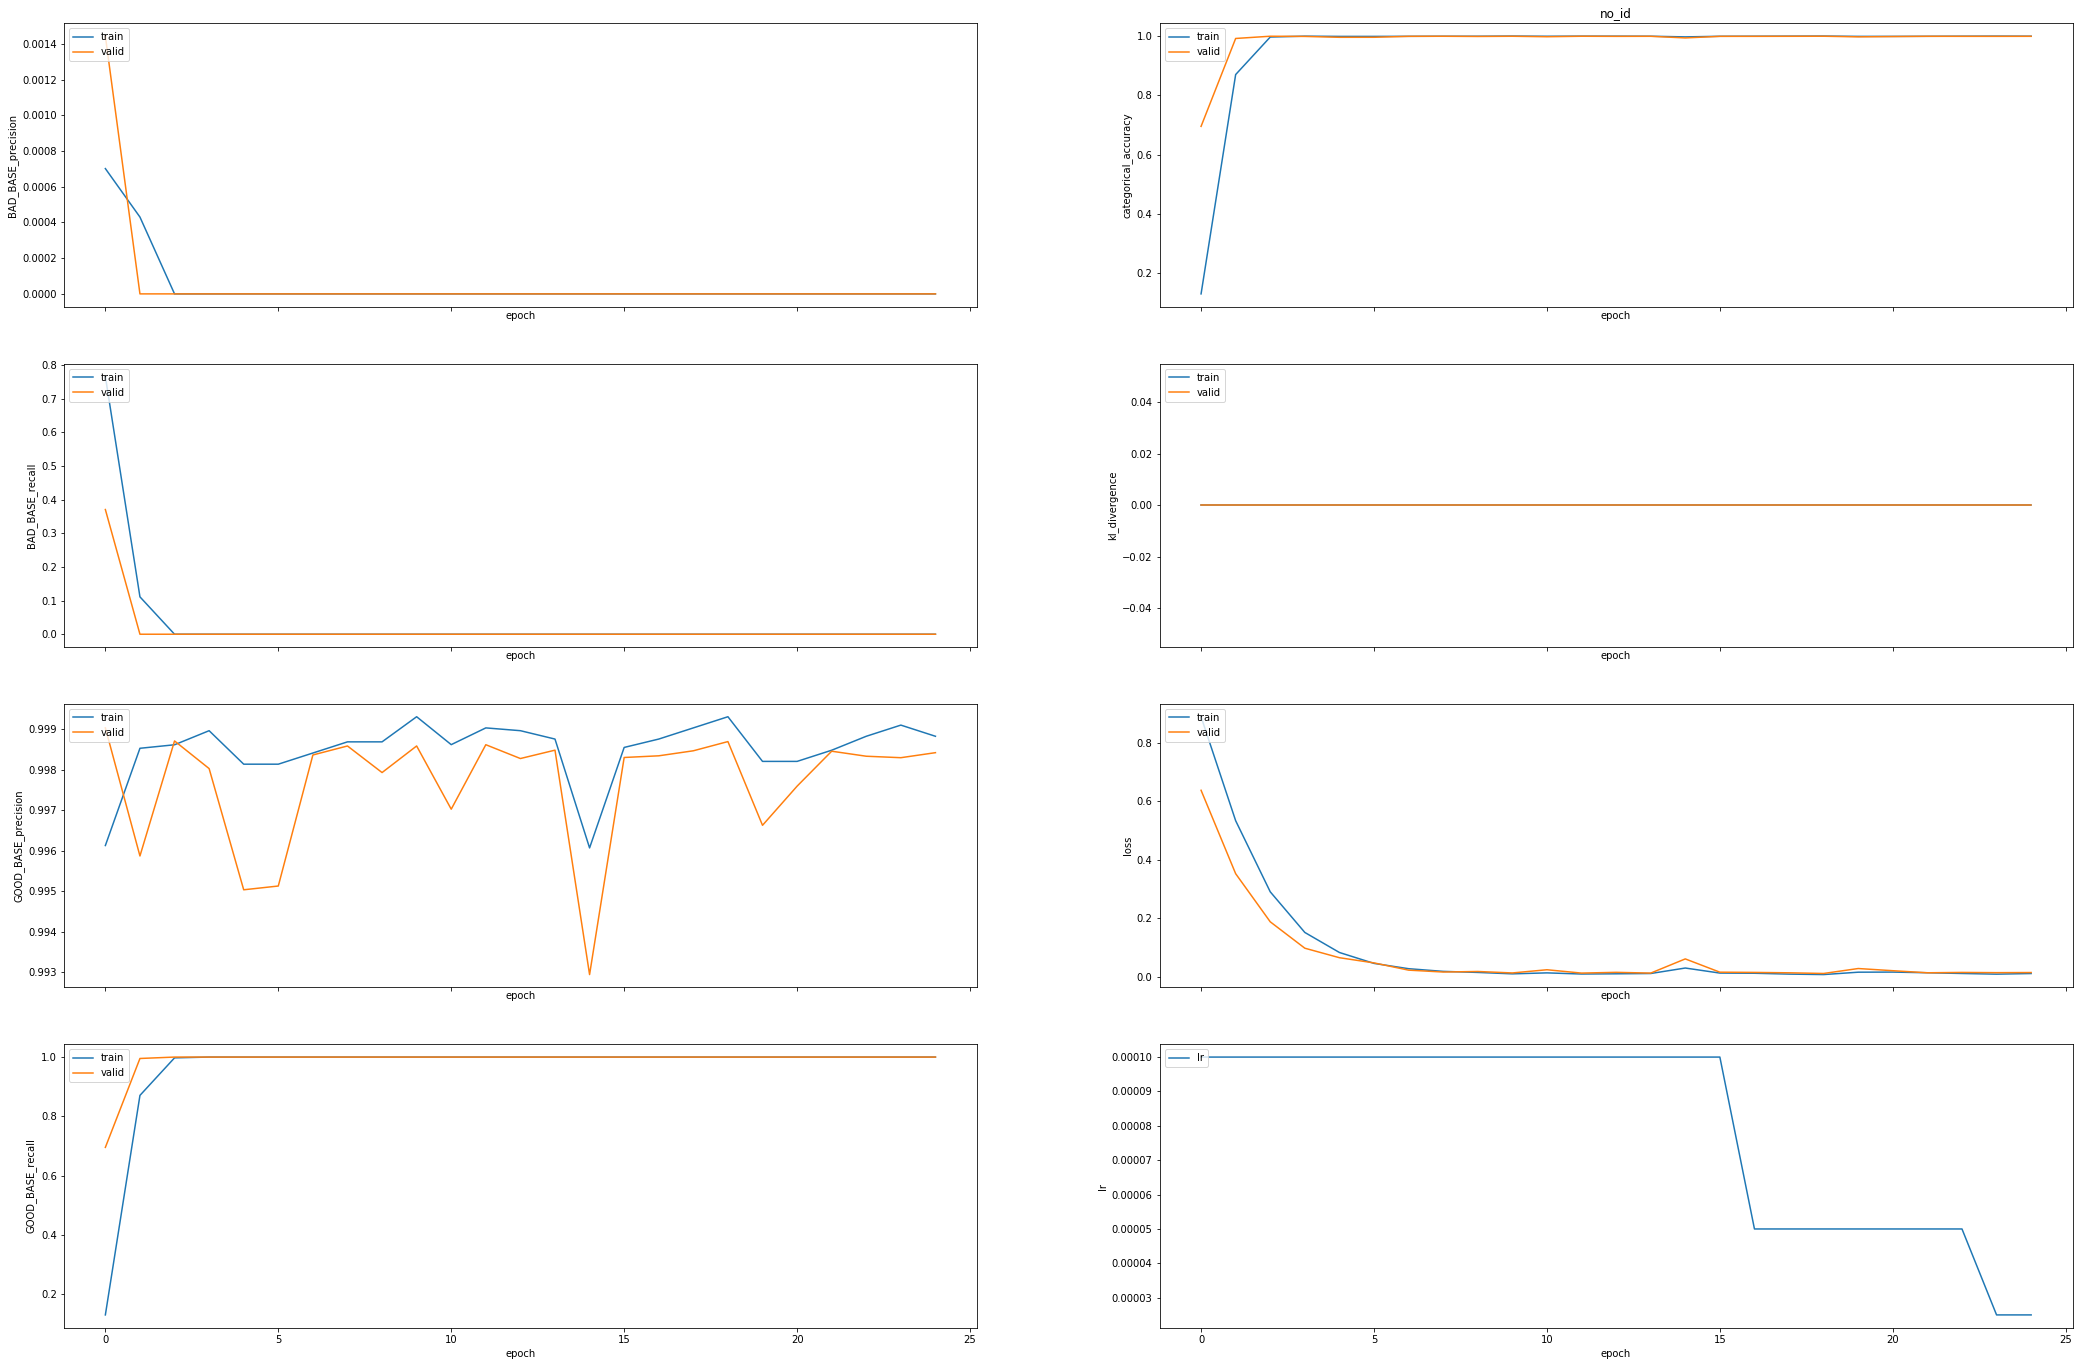

In [5]:
model = label_bases_model_from_args(args)
model = bqsr_train_model_from_generators(args, model, generate_train, generate_valid, args.output_dir+args.id+HD5_EXT)


In [3]:
values = np.random.randint(0, 2, 151) # 0 or 1
y_true = np.zeros((1,151,2))
y_true[0, np.arange(151), values] = 1

y_pred = np.zeros((1,151,2))
y_pred[0, :, 0] = 0.7 # match
y_pred[0, :, 1] = 0.3 # mismatch

t_true = tf.convert_to_tensor(y_true)
t_pred = tf.convert_to_tensor(y_pred)

with tf.Session():
    print(distance_in_mean(t_true, t_pred).eval())
    # TODO: KL divergence very much in construction still shouln't be zero - but what should it be?
    print(kl_divergence(t_true, t_pred).eval())

0.4
0.0


In [6]:
# tp = train_paths[0]
# tp = '/home/tsato/data/tensors/remove-all-error-reads/valid/NA12878_nist_na12878_minimal-HK35M.31_39752710.hd5'
# tp = '/home/tsato/data/tensors/remove-all-error-reads/train/NA12878_nist_na12878_minimal-HJYFJ.41_10087305.hd5'
tp = '/home/tsato/data/tensors/remove-all-error-reads-mini/train/NA12878_nist_na12878_minimal-HJYFJ.46_1000922.hd5'

with h5py.File(tp, 'r') as hf:
    tensor = np.array(hf.get(OQ_TENSOR_NAME))
    bqsr_tensor = np.array(hf.get(BQSR_TENSOR_NAME))

In [7]:
t = tf.constant([0.5, 0.0, 0.1, 0.0])
s = tf.constant([0.1, 0.0, 0.0, 0.7])
cross = t*tf.log(s)

td = tf.distributions.Categorical(probs=t)
sd = tf.distributions.Categorical(probs=s)

with tf.Session():
    print(t.eval())
    print(cross.eval())
    print(tf.where(tf.is_inf(cross), tf.zeros_like(cross), cross).eval())
    
    # print(tf.where(tf.is_nan(has_nans), tf.zeros_like(has_nans), has_nans).eval())


[ 0.5  0.   0.1  0. ]
[-1.15129256         nan        -inf -0.        ]
[-1.15129256         nan  0.         -0.        ]


In [8]:
t = tf.constant([1,2,3,4,5]) + 1
with tf.Session():
    print(t.eval())

[2 3 4 5 6]


In [9]:
t = tf.constant([0.01, 0.02, 0.03, 0.1 , 0.90, 0.9999])
mask = t > 0.01
r = tf.constant([0.0,1.0])
hist = tf.histogram_fixed_width(t, [0.0, 1.0], nbins=100) / 6
K.sum(hist)

with tf.Session():
    print(hist.eval())
# for i in np.arange(100):
#     print(hist[i])

[ 0.16666667  0.16666667  0.16666667  0.          0.          0.          0.
  0.          0.          0.          0.16666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.16666667
  0

In [10]:
import pysam
import vcf
from bqsr_cnn import write_reads_in_region_to_tensors
from Bio import SeqIO

args.bam_file = '/home/tsato/bam/NA12878.bam'
args.ignore_vcf = '/home/tsato/auxiliary/nist_na12878_minimal.vcf.gz'
args.bed_file = '/home/tsato/auxiliary/union13callableMQonlymerged_addcert_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs_v2.18_2mindatasets_5minYesNoRatio.bed'
args.reference_fasta = '/home/tsato/reference/Homo_sapiens_assembly19.fasta'

samfile = pysam.AlignmentFile(args.bam_file, "rb")
vcf_ram = vcf.Reader(open(args.ignore_vcf, 'rb'))

bed_dict = bqsr_bed_file_to_dict(args.bed_file)
record_dict = SeqIO.to_dict(SeqIO.parse(args.reference_fasta, "fasta"))


In [11]:
write_reads_in_region_to_tensors(args, samfile, contigs[i], c, start, stop - margin, stats)

NameError: name 'contigs' is not defined